In [1]:
import numpy as np
from numpy.linalg import norm

In [2]:
def read_orbcoef(file):
    '''Read MO coefficients from a Molcas (Ras)Orb file.'''
    
    orbitals=[]
    with open(file,"r") as stream:
        readorbitals=False
        anchor="pre-start"
        while not readorbitals and anchor!="":
            anchor=stream.readline()
            if "#INFO" in anchor and "orbitals" in stream.readline():
                stream.readline()
                norbitals=int(stream.readline())
                if (norbitals%5)!=0:
                    block=norbitals//5+1
                else:
                    block=norbitals//5
            elif "#ORB" in anchor:
                for orb in range(1,norbitals+1):
                    stream.readline()
                    coef_st=""
                    for row in range(block):
                        coef_st=coef_st+stream.readline()
                    orbitals.append(np.array(coef_st.split(),dtype="float"))
                readorbitals=True
                
    return np.array(orbitals)

In [25]:
def normalise_rows(mat):
    '''Normalise each row of mat'''
    return np.array(tuple(map(lambda v:v/norm(v),mat)))

def flip(v):
    '''Returns 1 if max(abs(v))) is positive, and -1 if negative'''
    maxpos=np.argmax(abs(v))
    return v[maxpos]/abs(v[maxpos])

def order_orbitals(ref,target):
    '''Reorder target molecular orbitals according to maximum overlap with ref.
    Orbitals phases are also adjusted to match ref.'''
    
    Moverlap=np.dot(normalise_rows(ref),normalise_rows(target).T)
    orb_order=np.argmax(abs(Moverlap), axis=1)
    target = target[orb_order]

    for idx in range(target.shape[0]):
        if np.dot(ref[idx], target[idx]) < 0:
            target[idx] = -1 * target[idx]

    return target

    
    # flip_phase=np.diag(tuple(map(flip,Moverlap)))
    # return np.dot(flip_phase,target)[orb_order]

In [4]:
def mse(ref,target):
    '''Mean squared error between ref and target orbital coefficients'''
    
    return (sum(((target-ref)**2).flatten()))/len(ref)**2

In [16]:
standard_orb=read_orbcoef("fulvene.Orb")

In [20]:
standard_orb.shape

(36, 36)

In [14]:
ml_orb=read_orbcoef("geom.MLOrb")
converged_from_ml=read_orbcoef("geom_ML.RasOrb")
converged_from_std=read_orbcoef("geom_std.RasOrb")

In [18]:
ml_orb_o=order_orbitals(standard_orb,ml_orb)
converged_from_ml_o=order_orbitals(standard_orb,converged_from_ml)
converged_from_std_o=order_orbitals(standard_orb,converged_from_std)

In [27]:
mse(converged_from_std_o,converged_from_ml_o)

0.06613961523811845

In [29]:
max((converged_from_std_o-converged_from_ml_o).flatten())

2.15748670796446

In [31]:
mse(converged_from_ml_o,ml_orb_o)

0.01603756170562079

In [32]:
mse(converged_from_std_o,standard_orb)

0.034231360638166015

In [5]:
import matplotlib.pyplot as plt

def plot_distribution(coeff, coeff2):
  error = [(coeff2.flatten()[i] - coeff.flatten()[i])**2 for i in range(len(coeff.flatten()))]
  plt.plot(np.arange(len(error)), error)
  plt.show()

In [6]:
def inner(ref, target):
  return np.dot(ref.flatten() / np.linalg.norm(ref.flatten()), target.flatten() / np.linalg.norm(target.flatten()))

def mce(ref, target):
  return (sum(((target-ref)**4).flatten()))/len(ref)**2
  

0.010660249288347941
0.020028267357857055
3.9844725523426053e-08


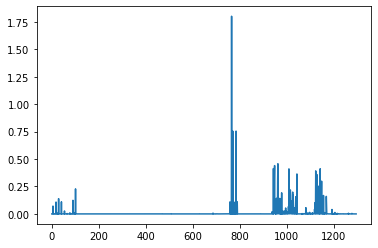

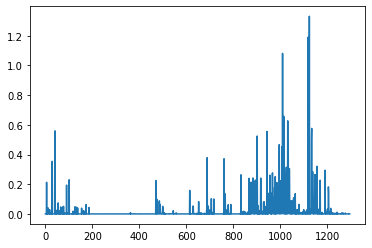

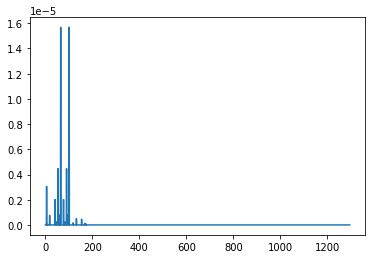

In [30]:
# lets build further on what Joao worked on previously
base_path = "C:/users/rhjva/imperial/molcas_files/fulvene_scan_2_experiment0_mse/geometry_191/"

ref = read_orbcoef('C:/users/rhjva/imperial/molcas_files/fulvene_scan_2/geometry_0/CASSCF/CASSCF.RasOrb')

ml_guess = read_orbcoef(base_path + 'CASSCF_ML/geom.orb') # geom.orb')
guess = order_orbitals(ref, read_orbcoef(base_path + 'CASSCF/geom.orb'))
guess_2 = order_orbitals(ref, read_orbcoef(base_path + 'CASSCF/geom.orb'))
ml_converged = order_orbitals(ref, read_orbcoef(base_path + 'CASSCF_ML/CASSCF_ML.RasOrb'))
guess_converged = order_orbitals(ref, read_orbcoef(base_path + 'CASSCF/CASSCF.RasOrb'))

# guess = read_orbcoef(base_path + 'CASSCF/geom.orb')
# guess_2 = read_orbcoef(base_path + 'CASSCF/geom.orb')
# ml_guess = read_orbcoef(base_path + 'CASSCF_ML/geom.orb')
# ml_converged = read_orbcoef(base_path + 'CASSCF_ML/CASSCF_ML.RasOrb')
# guess_converged = read_orbcoef(base_path + 'CASSCF/CASSCF.RasOrb')

print(mse(ml_guess, guess_converged))
print(mse(guess, guess_converged))
print(mse(ml_converged, guess_converged))

for i in range(36**2):
  if np.sign(ml_converged.flatten()[i]) != np.sign(guess_converged.flatten()[i]):
    print(i)
    print(ml_converged.flatten()[i], guess_converged.flatten()[i])

plot_distribution(ml_guess, ml_converged)
plot_distribution(guess, guess_converged)
plot_distribution(ml_converged, guess_converged)

geometry:  25
ml_guess:  0.020062728990008456
guess:  0.02624545069384105


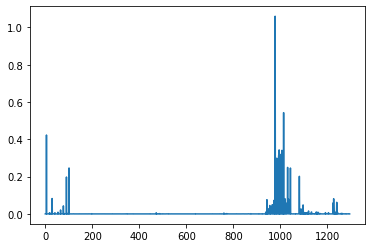

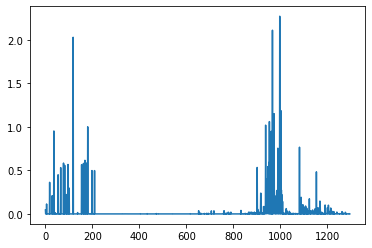

geometry:  35
ml_guess:  0.02008442789434796
guess:  0.02985904923917799


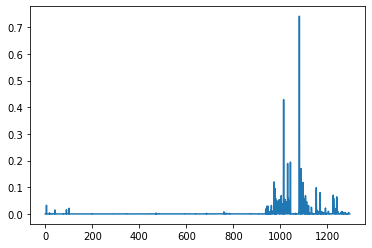

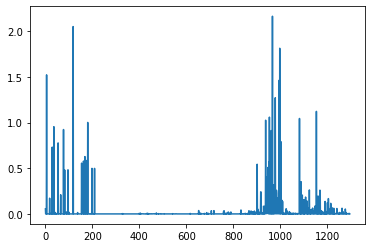

geometry:  54
ml_guess:  0.020674161244827488
guess:  0.034267127178540545


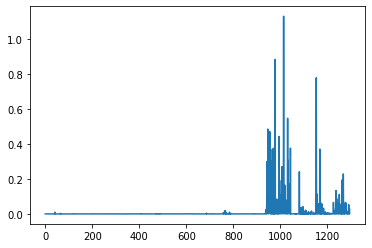

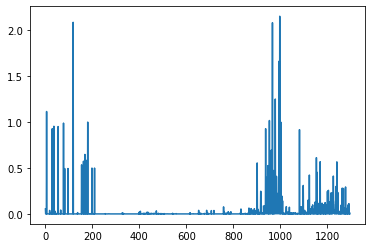

geometry:  191
ml_guess:  0.011979756098737564
guess:  0.03503304601482109


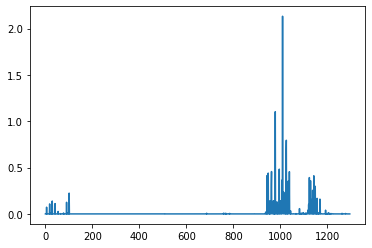

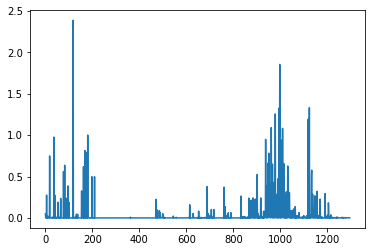

In [31]:
base_path = "C:/users/rhjva/imperial/molcas_files/fulvene_scan_2_experiment0_mse/geometry_"

ref = read_orbcoef('C:/users/rhjva/imperial/molcas_files/fulvene_scan_2/geometry_0/CASSCF/CASSCF.RasOrb')

for geometry in [25, 35, 54, 191]:
  base_pathh = base_path + str(geometry) + '/'

  ml_guess = order_orbitals(ref, read_orbcoef(base_pathh + 'CASSCF_ML/geom.orb'))
  guess = read_orbcoef(base_pathh + 'CASSCF/geom.orb')
  guess_converged = order_orbitals(ref, read_orbcoef(base_pathh + 'CASSCF/CASSCF.RasOrb'))

  print('geometry: ', geometry)
  print('ml_guess: ', mse(ml_guess, ml_converged))
  print('guess: ', mse(guess, guess_converged))
  plot_distribution(ml_guess, guess_converged)
  plot_distribution(guess, guess_converged)

In [32]:
def numpy_to_string(array: np.ndarray) -> str:
  string = ''

  for idx, elem in enumerate(array):
    if elem < 0:
      string += ' '
    else:
      string += '  '
    
    string += '%.14E' % elem

    if (idx + 1) % 5 == 0:
      string += '\n'
    if (idx + 1) == len(array):
      string += '\n'

  return string

def write_coeffs_to_orb_file(coeffs: np.ndarray, input_file_path: str, output_file_path: str, n: int) -> None:
  lines = []

  with open(input_file_path, 'r') as f:
    # add initial lines
    while True:
      line = f.readline()
      if '* ORBITAL' not in line:
        lines.append(line)
      else:
        break

    # add orbitals
    for i in range(1, n+1):
      lines.append(f'* ORBITAL \t 1 \t {i} \n')
      lines.append(numpy_to_string(coeffs[(i-1)*n:i*n]))

    append = False
    while True:
      line = f.readline()
      if '#OCC' in line:
        append = True

      if append:
        lines.append(line)

      if line == '':
        break
      
  with open(output_file_path, 'w+') as f:
    f.writelines(lines)

guess adjusted:  0.036367922725205566


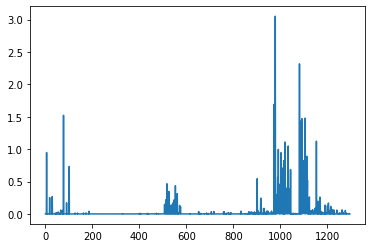

guess not adjusted:  0.04493714223681766


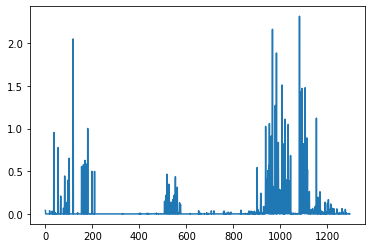

In [41]:
base_path = "C:/users/rhjva/imperial/molcas_files/fulvene_scan_2_experiment0_mse/geometry_35/"
ref = read_orbcoef('C:/users/rhjva/imperial/molcas_files/fulvene_scan_2/geometry_0/CASSCF/CASSCF.RasOrb')
guess = order_orbitals(ref, read_orbcoef(base_path + 'CASSCF/geom.orb'))
guess_converged = read_orbcoef(base_path + 'CASSCF/CASSCF.RasOrb')
print('guess adjusted: ', mse(guess, guess_converged))

# write_coeffs_to_orb_file(guess.flatten(), 'C:/users/rhjva/imperial/molcas_files/fulvene_scan_2/geometry_0/CASSCF/CASSCF.RasOrb', 'guess_adjusted.orb', 36)
plot_distribution(guess, guess_converged)


guess = read_orbcoef(base_path + 'CASSCF/geom.orb')
print('guess not adjusted: ', mse(guess, guess_converged))
# write_coeffs_to_orb_file(guess.flatten(), 'C:/users/rhjva/imperial/molcas_files/fulvene_scan_2/geometry_0/CASSCF/CASSCF.RasOrb', 'guess_not_adjusted.orb', 36)
plot_distribution(guess, guess_converged)

In [ ]:
# guess adjusted: 10 iterations
# guess not adjusted: 10 iterations

In [61]:
base_path = "C:/users/rhjva/imperial/molcas_files/fulvene_scan_2_experiment0_mse/geometry_35/"
# ref = read_orbcoef('C:/users/rhjva/imperial/molcas_files/fulvene_scan_2/geometry_0/CASSCF/CASSCF.RasOrb')
ref = read_orbcoef(base_path + 'CASSCF/geom.orb')
ml_guess = order_orbitals(ref, read_orbcoef(base_path + 'CASSCF_ML/geom.orb'))
guess_converged = order_orbitals(ref, read_orbcoef(base_path + 'CASSCF/CASSCF.RasOrb'))
print('guess adjusted: ', mse(ml_guess, guess_converged))

write_coeffs_to_orb_file(ml_guess.flatten(), 'C:/users/rhjva/imperial/molcas_files/fulvene_scan_2/geometry_0/CASSCF/CASSCF.RasOrb', 'mlguess_adjusted.orb', 36)

ml_guess = read_orbcoef(base_path + 'CASSCF_ML/geom.orb')
print('guess not adjusted: ', mse(ml_guess, guess_converged))
write_coeffs_to_orb_file(ml_guess.flatten(), 'C:/users/rhjva/imperial/molcas_files/fulvene_scan_2/geometry_0/CASSCF/CASSCF.RasOrb', 'mlguess_not_adjusted.orb', 36)

guess adjusted:  0.0305822792370365
guess not adjusted:  0.02965850108937987


In [ ]:
# guess adjusted -> 4 iterations
# guess not adjusted -> 4 iterations